In [1]:
import tqdm

%load_ext autoreload
%autoreload 2
import sys
import os
print(os.environ['LD_LIBRARY_PATH'])
sys.executable

/usr/local/cuda-12.6/lib64:~/.virtualenvs/dopamine/lib/python3.10/site-packages/nvidia/cudnn//lib:/home/eop/.mujoco/mujoco210/bin:/usr/lib/nvidia


'/home/eop/code/CORL/venv/bin/python'

In [2]:
import os
import random
import uuid
from dataclasses import asdict, dataclass
from pathlib import Path
from typing import Any, Dict, List, Optional, Tuple, Union

import d4rl
import gym
import numpy as np
import pyrallis
import torch
import torch.nn as nn
import torch.nn.functional as F
import wandb
from tqdm import tqdm, trange
import multiprocessing

multiprocessing.set_start_method('spawn', force=True)

No module named 'flow'
No module named 'carla'
pybullet build time: Nov 28 2023 23:45:17


In [3]:
env_name = 'halfcheetah-medium-v2'
env = gym.make(env_name)
dataset = env.get_dataset()
torch.set_default_device('cuda')

/home/eop/code/CORL/venv/lib/python3.10/site-packages/gym/spaces/box.py:84: UserWarning: WARN: Box bound precision lowered by casting to float32
  logger.warn(f"Box bound precision lowered by casting to {self.dtype}")
load datafile: 100%|████████████████████████████████████████████████████████████████████| 21/21 [00:01<00:00, 12.11it/s]


In [4]:
from algorithms.offline.knn import load_d4rl_trajectories

In [5]:
trajs, infos = load_d4rl_trajectories(env_name)
obs_shape = trajs[0]['observations'].shape[1]
action_shape=trajs[0]['actions'].shape[1]
obs_mean = infos['obs_mean']
obs_std = infos['obs_std']
print(obs_shape, action_shape)

/home/eop/code/CORL/venv/lib/python3.10/site-packages/gym/spaces/box.py:84: UserWarning: WARN: Box bound precision lowered by casting to float32
  logger.warn(f"Box bound precision lowered by casting to {self.dtype}")
load datafile: 100%|████████████████████████████████████████████████████████████████████| 21/21 [00:01<00:00, 12.79it/s]


Processing trajectories:   0%|          | 0/1000000 [00:00<?, ?it/s]

17 6


In [6]:
infos

{'obs_mean': array([[-0.06845774,  0.01641455, -0.18354906, -0.27624607, -0.34061527,
         -0.09339716, -0.21321271, -0.08774239,  5.1730075 , -0.04275195,
         -0.03610836,  0.14053793,  0.06049833,  0.09550975,  0.067391  ,
          0.00562739,  0.01338279]], dtype=float32),
 'obs_std': array([[ 0.07472999,  0.30234998,  0.3020731 ,  0.34417078,  0.17619242,
          0.5072056 ,  0.25670078,  0.32948127,  1.2574149 ,  0.7600542 ,
          1.9800916 ,  6.5653625 ,  7.4663677 ,  4.472223  , 10.566964  ,
          5.6719327 ,  7.498259  ]], dtype=float32),
 'reward_mean': array([4.7703357], dtype=float32),
 'reward_std': array([1.2101753], dtype=float32),
 'traj_lens': array([1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000,
        1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000,
        1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000,
        1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000,
        1000, 100

In [7]:
class QDataset(torch.utils.data.Dataset):
    
    def __init__(self, trajs, infos):
        self.trajs = trajs
        self.infos = infos
        self.obs_mean = infos['obs_mean']
        self.obs_std = infos['obs_std']
        self.traj_lens = np.array([traj['observations'].shape[0] for traj in trajs])
        self.next_state_distance_min = 1
        self.next_state_distance_max = 5
        self.next_state_distance_max_tensor = torch.tensor(self.next_state_distance_max, dtype=torch.float32)
        for traj in trajs:
            traj['observations'] = (traj['observations'] - self.obs_mean) / self.obs_std
            traj['rewards'] = (traj['rewards'] - traj['rewards'].mean()) / traj['rewards'].std()

        self.qdataset = dict()
        self.qdataset["observations"] = np.concatenate([traj["observations"][:-self.next_state_distance_max] for i, traj in enumerate(trajs) if self.traj_lens[i] > self.next_state_distance_max], axis=0)
        self.qdataset["actions"] = np.concatenate([traj["actions"][:-self.next_state_distance_max] for traj in trajs], axis=0)
        self.max_traj_len = max(self.traj_lens)
        self.reshuffle_next_state_distance()

    def reshuffle_next_state_distance(self):
        next_state_distance = np.random.randint(self.next_state_distance_min, self.next_state_distance_max, (len(self.trajs),self.max_traj_len))
        next_index = np.arange(self.max_traj_len) + next_state_distance
        self.qdataset["next_observations"] = np.concatenate([traj["observations"][next_index[i][:self.traj_lens[i]-self.next_state_distance_max]] for i, traj in enumerate(self.trajs) if self.traj_lens[i] > self.next_state_distance_max], axis=0)
        self.qdataset["distances_int"] = np.concatenate([next_state_distance[i][:self.traj_lens[i]-self.next_state_distance_max] for i, traj in enumerate(self.trajs) if self.traj_lens[i] > self.next_state_distance_max])
        self.qdataset["distances"] = self.qdataset["distances_int"].astype(np.float32)

    def __len__(self):
        return len(self.qdataset["observations"])

    def __getitem__(self, idx):
        return {
            'observations': self.qdataset["observations"][idx],
            'actions': self.qdataset["actions"][idx],
            'next_observations': self.qdataset["next_observations"][idx],
            'distances': self.qdataset["distances"][idx],
        }

all_data = QDataset(trajs, infos)

In [8]:
ind = 10
assert (all_data.qdataset['observations'][ind + all_data.qdataset['distances_int'][ind]] == all_data.qdataset['next_observations'][ind]).all()

In [9]:
class Encoder(nn.Module):
    def __init__(self, obs_shape: int, hidden_dim: int, latent_dim: int):
        super(Encoder, self).__init__()
        self.fc1 = nn.Linear(obs_shape, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, hidden_dim)
        self.fc4 = nn.Linear(hidden_dim, latent_dim)
        self.ln1 = nn.LayerNorm(hidden_dim)
        self.ln2 = nn.LayerNorm(hidden_dim)
        self.ln3 = nn.LayerNorm(hidden_dim)
    
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.ln1(x)
        x = F.relu(self.fc2(x))
        x = self.ln2(x)
        # x = F.relu(self.fc3(x))
        # x = self.ln3(x)
        return self.fc4(x)

class InvModel(nn.Module):
    def __init__(self, latent_dim: int, hidden_dim: int, action_shape: int):
        super(InvModel, self).__init__()
        self.fc1 = nn.Linear(latent_dim*2, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, hidden_dim)
        self.fc4 = nn.Linear(hidden_dim, action_shape)
        self.ln1 = nn.LayerNorm(hidden_dim)
        self.ln2 = nn.LayerNorm(hidden_dim)
        self.ln3 = nn.LayerNorm(hidden_dim)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.ln1(x)
        x = F.relu(self.fc2(x))
        x = self.ln2(x)
        # x = F.relu(self.fc3(x))
        # x = self.ln3(x)
        return self.fc4(x)

hidden_dim = 128
latent_dim = 16
encoder = Encoder(obs_shape=obs_shape, hidden_dim=hidden_dim, latent_dim=latent_dim)
target_encoder = Encoder(obs_shape=obs_shape, hidden_dim=hidden_dim, latent_dim=latent_dim)
inv_model = InvModel(latent_dim=latent_dim, hidden_dim=hidden_dim, action_shape=action_shape)

In [10]:
from torch.utils.data import DataLoader
from torch.optim import AdamW
from torch.optim.lr_scheduler import LambdaLR

batch_size = 256
target_ema = 0.995
epochs = 5
train_size = int(0.8 * len(trajs))
indices = np.random.permutation(len(trajs))
trajs_np = np.array(trajs)
train_idx, val_idx = indices[:train_size], indices[train_size:]
dataset, val_set = QDataset(trajs_np[train_idx], infos), QDataset(trajs_np[val_idx], infos)

dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, generator=torch.Generator(device='cuda'))
optimizer = AdamW(list(encoder.parameters()) + list(inv_model.parameters()), lr=1e-3)

def distance(z, z_next):
    return (z - z_next).norm(p=2, dim=-1)

def distance_loss(z, z_next, dist):
    distance_pred = distance(z, z_next)
    return F.mse_loss(distance_pred, dist)

def contrastive_loss(z, random_z):
    distance_pred = distance(z, random_z)
    return (distance_pred - all_data.next_state_distance_max_tensor.expand_as(distance_pred))[distance_pred < all_data.next_state_distance_max_tensor].pow(2).mean()

def train_step(batch):
    obs = batch['observations']
    act = batch['actions']
    next_obs = batch['next_observations']
    distances = batch['distances']

    z = encoder(obs)
    with torch.no_grad():
        z_next = target_encoder(next_obs)

    action_pred = inv_model(torch.cat([z, z_next], dim=-1))
    model_loss = distance_loss(z, z_next, distances)
    contrastive = contrastive_loss(z, z_next[torch.randperm(len(z))])
    action_loss = F.mse_loss(action_pred, act)
    loss = model_loss + action_loss + contrastive
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    # Update target encoder with exponential moving average
    for param, target_param in zip(encoder.parameters(), target_encoder.parameters()):
        target_param.data = target_param.data * target_ema + param.data * (1.0 - target_ema)
    
    return loss.item(), model_loss.item(), action_loss.item(), contrastive.item()

In [11]:
losses = []
model_losses = []
action_losses = []
contrastive_losses = []
for epoch in range(epochs):
    print(f"Epoch {epoch}")
    for batch in tqdm(dataloader):
        loss, model_loss, action_loss, contrastive = train_step(batch)
        losses.append(loss)
        model_losses.append(model_loss)
        action_losses.append(action_loss)
        contrastive_losses.append(contrastive)
    dataset.reshuffle_next_state_distance()


Epoch 0


100%|███████████████████████████████████████████████████████████████████████████████| 3110/3110 [01:54<00:00, 27.25it/s]


Epoch 1


100%|███████████████████████████████████████████████████████████████████████████████| 3110/3110 [01:49<00:00, 28.49it/s]


Epoch 2


100%|███████████████████████████████████████████████████████████████████████████████| 3110/3110 [01:50<00:00, 28.16it/s]


Epoch 3


100%|███████████████████████████████████████████████████████████████████████████████| 3110/3110 [01:51<00:00, 27.79it/s]


Epoch 4


100%|███████████████████████████████████████████████████████████████████████████████| 3110/3110 [01:51<00:00, 27.77it/s]


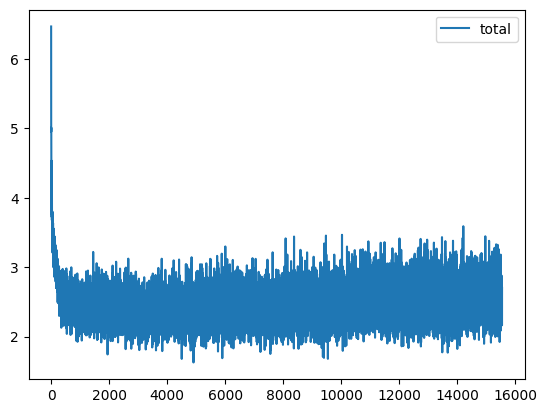

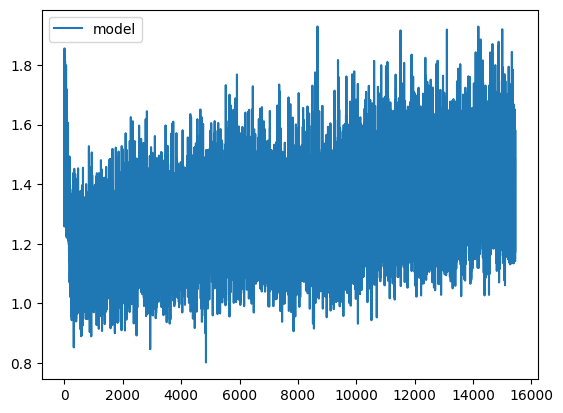

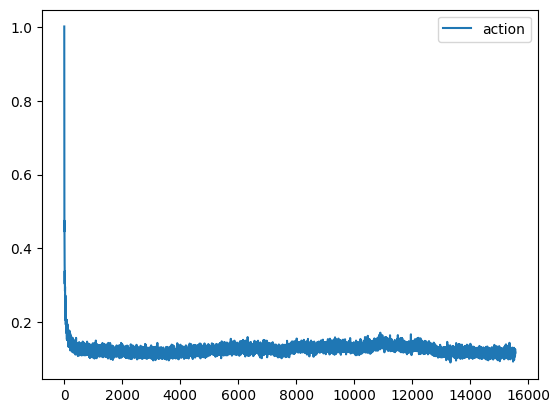

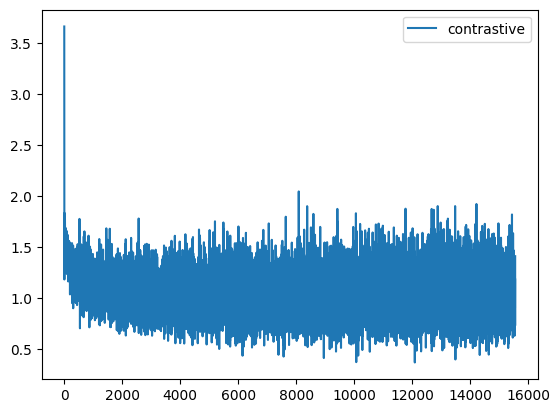

In [12]:
import matplotlib.pyplot as plt
plt.plot(losses, label='total')
plt.legend()
plt.show()


plt.plot(model_losses[100:], label='model')
plt.legend()
plt.show()

plt.plot(action_losses, label='action')
plt.legend()
plt.show()

plt.plot(contrastive_losses, label='contrastive')
plt.legend()
plt.show()

Model loss: 2.7405169010162354
Model loss (shuffle): 23.75417709350586


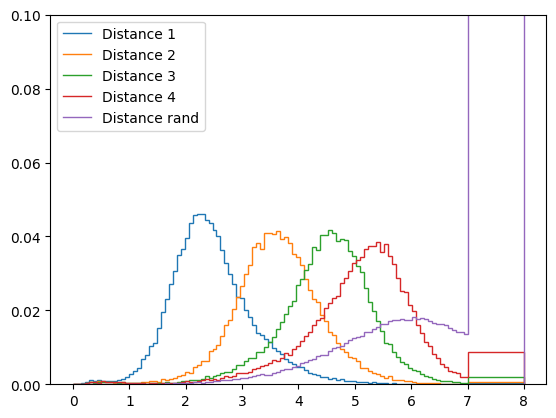

Model loss: 2.727860450744629
Model loss (shuffle): 24.047136306762695


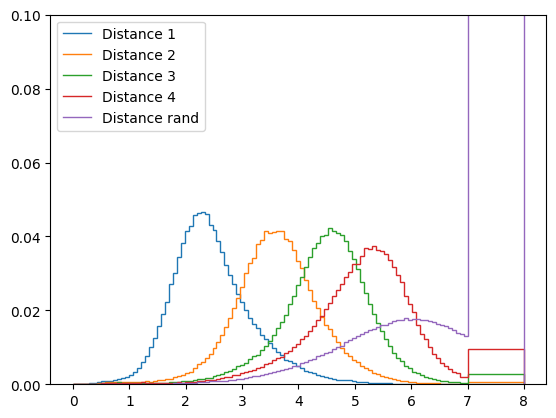

In [13]:
# validate that model is accurate

val_set_loader = DataLoader(val_set, batch_size=batch_size, shuffle=True, generator=torch.Generator(device='cuda'))


def plot_hists(loader):
    model_loss_total = 0
    model_loss_shuffle = 0
    bins = np.linspace(0, all_data.next_state_distance_max + 2, 100, endpoint=True)
    bins = np.concatenate([bins, [10000]])
    hists = dict()
    with torch.no_grad():
        for batch in loader:
            z = encoder(batch['observations'])
            z_next = encoder(batch['next_observations'])
            distances = batch['distances']
            distances_pred = distance(z, z_next)
            # compute histogram of distances
            for i in range(all_data.next_state_distance_min, all_data.next_state_distance_max+1):
                hists[i] = hists.get(i, np.zeros_like(bins[:-1]))
                hists[i] += np.histogram(distances_pred[distances == i].cpu().numpy(), bins=bins)[0]
            hists["rand"] = hists.get("rand", np.zeros_like(bins[:-1]))
            hists["rand"] += np.histogram(distance(z, z_next[torch.randperm(len(z))]).cpu().numpy(), bins=bins)[0]

            model_loss_total += distance_loss(z, z_next, distances)
            model_loss_shuffle += distance_loss(z, z_next[torch.randperm(len(z))], distances)
    print(
        f"Model loss: {model_loss_total / len(loader)}\n"
        f"Model loss (shuffle): {model_loss_shuffle / len(loader)}"
    )

    plotting_bins = np.copy(bins)
    plotting_bins[-1] = plotting_bins[-2] + 1
    for key, val in hists.items():
        if key in set(range(5, 1000)):
            continue
        val /= np.sum(val)
        plt.stairs(val, plotting_bins, label=f"Distance {key}")
    plt.legend()
    plt.ylim(0, 0.1)
    plt.show()

plot_hists(val_set_loader)
plot_hists(dataloader)

In [14]:
from pynndescent import NNDescent
from dataclasses import dataclass
    
num_obs = np.sum(infos['traj_lens'])

obs_norm = np.zeros((num_obs, latent_dim), dtype=np.float32)
z_next = np.zeros((num_obs, latent_dim), dtype=np.float32)

returns = np.zeros(num_obs, dtype=np.float32)
actions = np.zeros((num_obs, trajs[0]['actions'].shape[1]), dtype=np.float32)

next_state_distance = 3
ind = 0
for traj in tqdm(trajs):
    indices = slice(ind, ind+traj['observations'].shape[0] - next_state_distance)
    obs = traj['observations']
    z = encoder(torch.tensor(obs, dtype=torch.float32)).detach().cpu().numpy()
    obs_norm[indices] = z[:-next_state_distance]
    z_next[indices] = z[next_state_distance:]
    returns[indices] = traj['returns'][:-next_state_distance]
    actions[indices] = traj['actions'][:-next_state_distance]
    ind += traj['observations'].shape[0] - next_state_distance

100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 1435.45it/s]


In [15]:
index = NNDescent(obs_norm, metric='euclidean')

/home/eop/code/CORL/venv/lib/python3.10/site-packages/numba/np/ufunc/parallel.py:371: NumbaWarning: The TBB threading layer requires TBB version 2021 update 6 or later i.e., TBB_INTERFACE_VERSION >= 12060. Found TBB_INTERFACE_VERSION = 12050. The TBB threading layer is disabled.
  warnings.warn(problem)


In [20]:
from algorithms.offline.knn import wrap_env

eval_env = wrap_env(
    env=gym.make(env_name),
    state_mean=obs_mean,
    state_std=obs_std,
    reward_scale=1.0,
)
eval_episodes = 100
k=1


In [27]:
idx, dist = index.query(eval_env.reset(), k=500)
idx.shape, idx, dist

((1, 500),
 array([[757222, 280078, 720223, 150424, 565268, 196845, 385453, 699589,
         723377, 699590,  80703,  55019, 175773, 716225, 382055, 847638,
         835669, 470981, 559090, 527208, 175774, 652906, 690623, 529140,
          64579, 175771, 230483, 738327,  90848, 324946, 527207, 604897,
         527206, 656396,  90849, 499281, 888703, 436798, 723378, 305491,
         546035, 156082, 716663, 699591, 304049, 527209, 565269, 847635,
         710147, 305490, 699592, 448300, 846816, 272759, 364501, 385454,
         488633, 765062, 196847, 643392, 128800, 724175, 727521, 865939,
         461302, 966185, 381129,  38081, 906461, 559091, 980260, 476700,
         490030, 823738, 727520,  77134, 990673, 592773, 880430, 864279,
         361389, 159366, 753610, 196846, 639758, 568817, 950925, 395109,
         607059, 563947, 847639, 888702, 312994, 563302,  27613, 653238,
         805486, 369647, 847640, 675713, 711743, 970909, 253884, 800339,
         875981,  77874, 947084, 142308,

In [19]:

def eval():
    obs = eval_env.reset()
    done = False
    total_reward = 0.0
    while not done:
        z = encoder(torch.tensor(obs, dtype=torch.float32).unsqueeze(0)).detach().cpu().numpy()
        idxs, dists = index.query(z[0], k=k)
        neighbor_rets = returns[idxs]
        ranks = neighbor_rets * np.exp(-1 * dists)
        best_idx = idxs[0, np.argmax(ranks)]

        action = actions[best_idx]
        obs, reward, done, _ = eval_env.step(action)
        total_reward += reward
    return total_reward


eval_rets = [eval() for _ in trange(eval_episodes, desc="Evaluation", leave=False)]
np.mean(eval_rets), env.get_normalized_score(np.mean(eval_rets)) * 100.0

(58.082798918874644, 2.724582168323374)

In [18]:
def eval_inv_model():
    obs = eval_env.reset()
    done = False
    total_reward = 0.0
    while not done:
        z = encoder(torch.tensor(obs, dtype=torch.float32).unsqueeze(0)).detach().cpu().numpy()[0]
        idxs, dists = index.query(z, k=k)
        neighbor_rets = returns[idxs]
        ranks = neighbor_rets * np.exp(-1 * dists)
        best_idx = idxs[0, np.argmax(ranks)]

        action = inv_model(torch.tensor(np.concatenate([z, z_next[best_idx][None,:]], axis=-1), dtype=torch.float32).unsqueeze(0)).detach().cpu().numpy()
        obs, reward, done, _ = eval_env.step(action.squeeze())
        total_reward += reward
    return total_reward


eval_rets_inv = [eval_inv_model() for _ in trange(eval_episodes, desc="Evaluation", leave=False)]
np.mean(eval_rets_inv), env.get_normalized_score(np.mean(eval_rets_inv)) * 100.0

(-284.9192941391744, -0.03818181886157146)

0.0007465858083766792